<a href="https://colab.research.google.com/github/RaminTK/Hoboken-Resiliency/blob/main/Hoboken_Resiliency_Sim_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Survey Simulation

In [ ]:
def change_values(x):
    if x == 1:
        return 0
    elif x == 2:
        return 0.25
    elif x == 3:
        return 0.5
    elif x == 4:
        return 0.75
    elif x == 5:
        return 1
    else:
        return x

def normalize(df1):
  df1 = df1.applymap(change_values)
  for i in range(0, df1.shape[1], 3):
      group_sum = df1.iloc[:, i:i+3].sum(axis=1)
      df1.iloc[:, i:i+3] = df1.iloc[:, i:i+3].div(group_sum, axis=0)
  df1.fillna(1/3,inplace = True)
  return df1



def cumulator (df):
  grouped_df = df.values.reshape(-1, 3)
  cumulative_sum = pd.DataFrame(grouped_df).cumsum(axis=1).values.flatten()
  cdf = pd.DataFrame(cumulative_sum.reshape(df.shape), columns=df.columns)
  return cdf


def sim(cdf1,simNum):
  new_df = pd.DataFrame(columns=cdf1.columns)
  scenario = list(range(6))
  simulation = []
  for s in scenario:
    temp_df = df1.iloc[:, 3*s:3*s+3]
    path = []
    for _ in range(simNum):
        random_row = temp_df.sample(n=1)
        rnd = np.random.rand()
        if rnd < random_row.iloc[:,0].values:
            selection = 1
        elif rnd < random_row.iloc[:,1].values:
            selection = 2
        else:
            selection = 3
        path.append(selection)
    simulation.append(path)

  df = pd.DataFrame(simulation).T
  df.columns = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
  return df


* blue = 1
* black = 2
* brown = 3


In [ ]:
cdf1 = cumulator(normalize(pd.read_csv('drive/MyDrive/Raif/d1.csv')))
cdf2 = cumulator(normalize(pd.read_csv('drive/MyDrive/Raif/d2.csv')))
cdf3 = cumulator(normalize(pd.read_csv('drive/MyDrive/Raif/p1.csv')))
cdf4 = cumulator(normalize(pd.read_csv('drive/MyDrive/Raif/p2.csv')))

# print('group1 - D1')
results = sim(cdf2,1000)
for s in results.columns:
  print(results[s].value_counts())
  print()

# results['S1'].value_counts()

MCS = sim(cdf1,1000)['S1'].value_counts()

1    429
3    389
2    182
Name: S1, dtype: int64

1    491
3    368
2    141
Name: S2, dtype: int64

1    633
3    348
2     19
Name: S3, dtype: int64

1    663
3    314
2     23
Name: S4, dtype: int64

1    597
3    386
2     17
Name: S5, dtype: int64

1    617
3    358
2     25
Name: S6, dtype: int64



In [ ]:
flow = 1000 # Adjust to experiments


SSUE

In [ ]:
def incid(path, edge):
    """
    Parameters
    ----------
    path : list
        Sequence of nodes contained in the node (compatible with Networkx shortest
        path outputs).
    edge : list
        Pair of nodes that constitute a given link (ordered).

    Returns
    -------
    int
        Returns 1 if edge is in path, 0 otherwise.
    """
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    if edge in edges:
        return 1
    else:
        return 0


def link_impBPR(free_flow_tt, x, capacity=None, a=0.15, b=4):
    """
    Parameters
    ----------
    Note: free_flow_tt, x and capacity must be in the same edge order.

    free_flow_tt : numpy array
        Array containing free-flow travel times.
    x : numpy array
        Array containing link loads.
    capacity : numpy array, float, optional
        Array or float containing link capacities. Defaults to 760 veh/h
    a : float, optional
        Alpha parameter for BPR function (check out HCM2000). The default is 0.15.
    b : float, optional
        Beta parameter for BPR function (check out HCM2000). The default is 4.0.

    Returns
    -------
    numpy array
        Returns the loaded travel times (impedance) for all links in a numpy array.

    """
    if capacity == None:
        capacity = np.ones(shape=x.shape) * 760
    elif type(capacity) == float:
        capacity = np.ones(shape=x.shape) * capacity
    elif type(capacity) != type(np.array):
        raise TypeError("Please input link capacity in either float or numpy array format")
    return free_flow_tt * (1 + a * (x / capacity) ** b)

def cost_funcBPR(alpha, x, y, free_flow_tt, capacity=None, a=0.15, b=4):
    """
    Parameters
    ----------
    Note: free_flow_tt, x, y and capacity must be in the same edge order.

    alpha : float
        Step size in the y direction.
    x : numpy array
        Current iteration position vector in a numpy array format.
    y : numpy array
        Iteration step direction vector in a numpy array format.
    free_flow_tt : numpy array
        Free flow travel time vector in a numpy array format.
    capacity : numpy array, float, optional
        Array or float containing link capacities. Defaults to 760 veh/h.
    a : float, optional
        Alpha parameter for BPR function (check out HCM2000). The default is 0.15.
    b : float, optional
        Beta parameter for BPR function (check out HCM2000). The default is 4.0.

    Returns
    -------
    numpy array
        Returns the gradient with respect to the step size alpha in a numpy array format.

    """
    if capacity == None:
        capacity = np.ones(shape=x.shape) * 760
    elif type(capacity) == float:
        capacity = np.ones(shape=x.shape) * capacity
    elif type(capacity) != type(np.array):
        raise TypeError("Please input link capacity in either float or numpy array format")
    nx = x + (y - x) * alpha
    return sum(nx * (free_flow_tt + a / b * (nx / capacity) ** b))


def MonteCarlo(lttime, incidence, beta=0.2, niter=100):
    """


    Parameters
    ----------
    lttime : numpy array
        n x 1 array of loaded link travel times (impedance), in numpy array format.
    incidence : numpy array
        n x k matrix of link incidence for each path, should contain 1 if link i is contained
        in path k, and 0 otherwise.
    beta : float, optional
        ratio between mean and standard deviation. The default is 0.2.
    niter : int, optional
        Number of Monte Carlo simulation iterations to be used. The default is 100.

    Raises
    ------
    TypeError
        Travel time and incidence matrix are not of the same length.

    Returns
    -------
    numpy array
        Link usage likelihood (n x 1).
    numpy array
        Path usage likelihood (k x 1).

    """
    if lttime.shape[0] != incidence.shape[1]:
        raise TypeError("travel time and incidence matrix not of same length")
    pusage = np.zeros(shape=(incidence.shape[0],))
    y = np.zeros(shape=(incidence.shape[1],))
    for i in range(niter):
        ttime = np.random.normal(loc=lttime, scale=beta * lttime)
        indmin = np.argmin(incidence.dot(ttime))
        pusage[indmin] += 1
        y += incidence[indmin, :].T
    return y / niter, pusage / niter


def kpaths(G, origin, destination, weight=None, lamb=0.4, k=5):
    """
    Returns up to k distinct paths using the link penalization methods
    Parameters
    ----------
    G : networkx.DiGraph()
        Graph containing nodes and vectors available for users in networkx directed
        graph format.
    origin: object
        Origin node for k path calculation.
    destination : object
        Destination node for k path calculation.
    weight : string, optional
        Link attribute containing link weights for shortest path calculation. The default is 0.4.
    lamb : float, optional
        Penalization factor lambda. The default is 0.4.
    k : int, optional
        Number of iterations. The default is 5.

    Returns
    -------
    paths : TYPE
        DESCRIPTION.

    """
    H = G.copy()
    paths = []
    for i in range(k):
        path = nx.dijkstra_path(H, origin, destination, weight=weight)
        if path not in paths:
            paths.append(path)
        for j in range(len(path) - 1):
            H[path[j]][path[j + 1]]['length'] *= (1 + lamb)
    return paths


def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float, axis=1)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, (n - 1):] / n



{('Origin', 'Destination'): array([[1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1]])}
[5.7 7.8 9.3 0.  0.  0. ]
[840. 160.   0. 840. 160.   0.]
[740. 200.  60. 740. 200.  60.]
[740. 190.  70. 740. 190.  70.]
[725.  192.5  82.5 725.  192.5  82.5]
[708. 204.  88. 708. 204.  88.]
[706.66666667 210.          83.33333333 706.66666667 210.
  83.33333333]
[711.42857143 202.85714286  85.71428571 711.42857143 202.85714286
  85.71428571]
[713.75 201.25  85.   713.75 201.25  85.  ]
[712.22222222 204.44444444  83.33333333 712.22222222 204.44444444
  83.33333333]
[711. 207.  82. 711. 207.  82.]
[710.90909091 210.          79.09090909 710.90909091 210.
  79.09090909]
[717.5        206.66666667  75.83333333 717.5        206.66666667
  75.83333333]
[713.07692308 210.          76.92307692 713.07692308 210.
  76.92307692]
[711.42857143 208.57142857  80.         711.42857143 208.57142857
  80.        ]
[707.33333333 208.66666667  84.         707.33333333 208.66666667
  84.       

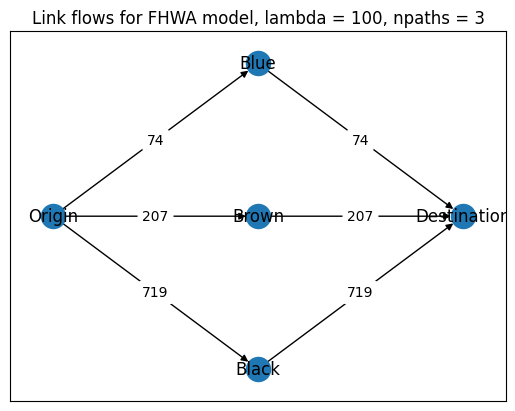

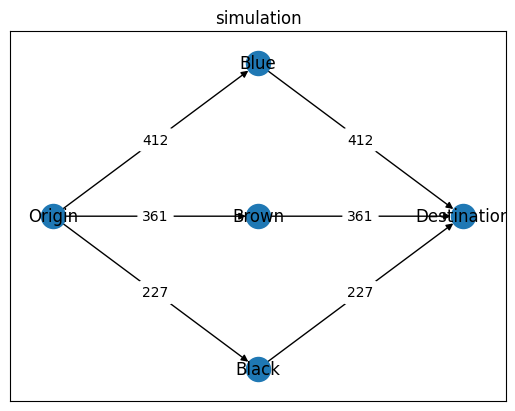

In [ ]:

# =============================================================================
# Build the graph
# =============================================================================
# grid = 5
speed_limit = 20/60 #m/min

G = nx.DiGraph()

G.add_node('Origin', pos = (0, 1))
G.add_node('Black', pos = (1, 0))
G.add_node('Brown', pos = (1, 1))
G.add_node('Blue', pos = (1, 2))
G.add_node('Destination', pos = (2, 1))

G.add_edge('Origin', 'Black', length=1.9/speed_limit, flow=0) #Black
G.add_edge('Black', 'Destination', length=0/speed_limit, flow=0) #Black
G.add_edge('Origin', 'Brown', length=2.6/speed_limit, flow=0) #Brown
G.add_edge('Brown', 'Destination', length=0/speed_limit, flow=0) #Brown
G.add_edge('Origin', 'Blue', length=3.1/speed_limit, flow=0) #Blue
G.add_edge('Blue', 'Destination', length=0/speed_limit, flow=0) #Blue


G2 = nx.DiGraph()

G2.add_node('Origin', pos = (0, 1))
G2.add_node('Black', pos = (1, 0))
G2.add_node('Brown', pos = (1, 1))
G2.add_node('Blue', pos = (1, 2))
G2.add_node('Destination', pos = (2, 1))

G2.add_edge('Origin', 'Black', length=1.9/speed_limit, flow=0) #Black
G2.add_edge('Black', 'Destination', length=0/speed_limit, flow=0) #Black
G2.add_edge('Origin', 'Brown', length=2.6/speed_limit, flow=0) #Brown
G2.add_edge('Brown', 'Destination', length=0/speed_limit, flow=0) #Brown
G2.add_edge('Origin', 'Blue', length=3.1/speed_limit, flow=0) #Blue
G2.add_edge('Blue', 'Destination', length=0/speed_limit, flow=0) #Blue


# %%
# =============================================================================
# Find paths, set OD pair flow, and initialize flows
# =============================================================================
# Path enumeration parameters
lamb = 100
npaths = 3
edges = G.edges
capacity = 760.   # According to HCM, capacity fo each lane in a unidirectional road can be 1,200 to 1,800 vehicle/hour

# Set origins and destination flows:
TAZ = {}
TAZ[('Origin', 'Destination')] = flow # Adjust to experiments

# Set paths and incidence matrices for each OD pair:
ODpaths = {ODpair: kpaths(G, origin=ODpair[0], destination=ODpair[1], weight='length',
                          lamb=lamb, k=npaths) for ODpair, flow in TAZ.items()}
ODincidence = {ODpair: np.array([[incid(path, edge) for edge in edges] for path in paths]) for ODpair, paths in
               ODpaths.items()}
print(ODincidence)
# Initialize flows
x = np.zeros(shape=(len(G.edges),))
lengths = np.array([G[edge[0]][edge[1]]['length'] for edge in edges])
print(lengths)
# =============================================================================
# Traffic assignment (MSA to solve SSUE (Static Stochastic User Equilibrium)
# =============================================================================
##### Ramin, when implementing your Monte Carlo simulation, run it here.
# Output of this portion of the code: x as an array with the flows of each edge in graph G.
# To access the sequence of edges for verification, you can run G.edges()

MCS = sim(cdf2,1000)['S1'].value_counts()

#Set parameters
beta = 0.2 # Sets uncertainty (higher beta means less certainty of travel times).
niter = 100 # Number of iterations for Monte Carlo simulation to ensure convergence of equilibrium traffic assignment
m = 5 # Number of non-improving iterations for checking convergence
xbar = np.zeros(shape=(len(G.edges), m + 1))

#Run traffic assignment
for n in range(100):
    y = np.zeros(shape=(len(G.edges),))
    for ODpair, flow in TAZ.items():
        incidence = ODincidence[ODpair]
        lttime = link_impBPR(lengths, x, capacity=capacity) # Translates to total travel time across all drivers
        yrs, _ = MonteCarlo(lttime, incidence, beta, niter) # Runs a Monte Carlo simulation to find the equilibrium given path time uncertainty
        y += flow * yrs
    x = x + (y - x) / (n + 1)
    print(x)
    xbar[:, :m] = xbar[:, 1:]
    xbar[:, m] = x
    if n >= m + 1:
        stop = np.sqrt(sum((np.mean(xbar[:, 1:], axis=1) - np.mean(xbar[:, :m], axis=1)) ** 2)) / sum(
            np.mean(xbar[:, :m], axis=1))
        if stop <= 10 ** (-4):
            break

#Assign resulting flows to Graph (visualization)
for k, edge in enumerate(edges):
    i = edge[0]
    j = edge[1]
    G[i][j]['flow'] = x[k]
# %%
# =============================================================================
# Draw the graph:
# =============================================================================

leng = {(n[0], n[1]): n[2]['length'] for n in G.edges(data=True)}
pos = {n[0]: n[1]['pos'] for n in G.nodes(data=True)}
fl = {(n[0], n[1]): round(n[2]['flow']) for n in G.edges(data=True)}

f, ax = plt.subplots()
ax.set_title('Link flows for FHWA model, lambda = ' + str(lamb) + ', npaths = ' + str(npaths))
nx.draw_networkx(G, pos=pos, with_labels=True, ax=ax)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=fl, rotate=False, ax=ax)

# f, ax = plt.subplots()
# ax.set_title("Total cost as a function of npaths and lambda")
# plt.xlabel("lambda")
# plt.ylabel("Total cost (10k units)")
# for npaths in p:
#     ax.scatter(l, ttime[npaths], label = "npaths = "+str(npaths))
#     ax.plot(l, ttime[npaths])
# ax.legend()


f2 = fl
f2[('Origin', 'Black')], f2[('Black', 'Destination')] = MCS[2],MCS[2]
f2[('Origin', 'Brown')], f2[('Brown', 'Destination')] = MCS[3],MCS[3]
f2[('Origin', 'Blue')], f2[('Blue', 'Destination')] = MCS[1],MCS[1]
f, ax = plt.subplots()
ax.set_title('simulation')
nx.draw_networkx(G2, pos=pos, with_labels=True, ax=ax)
_ = nx.draw_networkx_edge_labels(G2, pos=pos, edge_labels=f2, rotate=False, ax=ax)

In [ ]:
# Speed = 20
# Capacity = 2000
# Distance = 2
# Congestion = (flow / Capacity)
# Time = Distance / (Speed * (1 - Congestion))

# Time*60

Static Deterministic User Equilibrium

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 12 13:48:01 2020

@author: raif
"""


def incid(path, edge):
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    if edge in edges:
        return 1
    else:
        return 0


def link_impBPR(free_flow_tt, x, capacity=None, a=0.15, b=4):
    """
    Parameters
    ----------
    Note: free_flow_tt, x and capacity must be in the same edge order.

    free_flow_tt : numpy array
        Array containing free-flow travel times.
    x : numpy array
        Array containing link loads.
    capacity : numpy array, float, optional
        Array or float containing link capacities. Defaults to 760 veh/h
    a : float, optional
        Alpha parameter for BPR function (check out HCM2000). The default is 0.15.
    b : float, optional
        Beta parameter for BPR function (check out HCM2000). The default is 4.0.

    Returns
    -------
    numpy array
        Returns the loaded travel times (impedance) for all links in a numpy array.

    """
    if capacity == None:
        capacity = np.ones(shape=x.shape) * 760
    elif type(capacity) == float:
        capacity = np.ones(shape=x.shape) * capacity
    elif type(capacity) != type(np.array):
        raise TypeError("Please input link capacity in either float or numpy array format")

    return free_flow_tt * (1 + a * (x / capacity) ** b)


def cost_func(alpha, x, y, lengths, incidence, gamma=0.1):
    return max(link_impBPR(lengths, (x + (y - x) * alpha), gamma).dot(incidence.T))


def gss(cost_func, x, y, lengths, incidence, a=0, b=1, tol=1e-5, gamma=0.1):
    # Adapted from:
    # https://en.wikipedia.org/wiki/Golden-section_search
    gr = (np.sqrt(5) + 1) / 2
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    while abs(c - d) > tol:
        if cost_func(c, x, y, lengths, incidence) < cost_func(d, x, y, lengths, incidence):
            b = d
        else:
            a = c

        # We recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr

    return (b + a) / 2

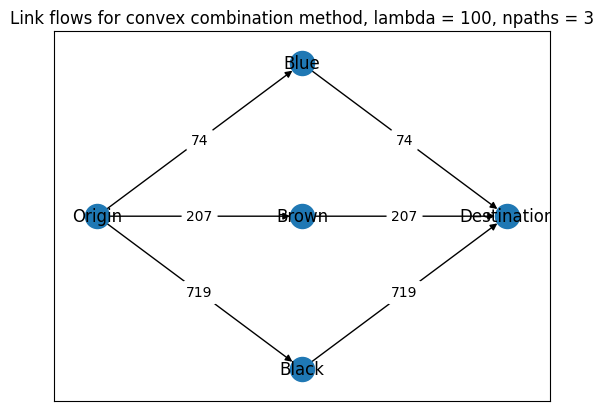

In [ ]:
# =============================================================================
# Build the graph
# =============================================================================
G = nx.DiGraph()

G.add_node('Origin', pos = (0, 1))
G.add_node('Black', pos = (1, 0))
G.add_node('Brown', pos = (1, 1))
G.add_node('Blue', pos = (1, 2))
G.add_node('Destination', pos = (2, 1))

G.add_edge('Origin', 'Black', length=1.9, flow=0) #Black
G.add_edge('Black', 'Destination', length=0, flow=0) #Black
G.add_edge('Origin', 'Brown', length=2.6, flow=0) #Brown
G.add_edge('Brown', 'Destination', length=0, flow=0) #Brown
G.add_edge('Origin', 'Blue', length=3.1, flow=0) #Blue
G.add_edge('Blue', 'Destination', length=0, flow=0) #Blue

# %%
# =============================================================================
# Find paths, set OD pair flow, and initialize flows
# =============================================================================
niter=100
# flow = 10 # Adjust to experiments
npaths = 3
lamb = 100
capacity = 760.

#Enumerate paths
H = G.copy()
paths = []
for i in range(npaths):
    path = nx.dijkstra_path(H, 'Origin', 'Destination', weight='length')
    if path not in paths:
        paths.append(path)
    for j in range(len(path)-1):
        H[path[j]][path[j+1]]['length'] *= (1+lamb)
del H

edges = G.edges
lengths = np.array([G[edge[0]][edge[1]]['length'] for edge in edges])
incidence = np.array([[incid(path, edge) for edge in edges] for path in paths])
for i in range(niter):
    # Step 1: Update link travel times.
    lttime = link_impBPR(lengths, x, capacity=capacity)
    indmin = np.argmin(incidence.dot(lttime))
    # Step 2: Find step direction with another all-or-nothing assignment.
    y = incidence[indmin, :].T * flow
    xp = x
    # Step 3: Find alpha that minimizes individual travel time (I used the
    # golden secion search method)
    alpha = gss(cost_func, x, y, lengths, incidence)
    # Step 4: Move to new point using alpha and the direction y
    x = (x + (y - x) * alpha)
    # Step 5: Check for convergence, if not, go back to step 1.
    stop = np.sqrt(sum((x - xp) ** 2)) / sum(xp)
    if stop <= 10 ** (-3):
        break
    if i == (niter - 1):
        print("Convex combination algorithm timed out")
lttime = link_impBPR(lengths, x)

for k, edge in enumerate(edges):
    i = edge[0]
    j = edge[1]
    G[i][j]['flow'] = x[k]

# %%
# =============================================================================
# Draw the graph:
# =============================================================================
leng = {(n[0], n[1]): n[2]['length'] for n in G.edges(data=True)}
pos = {n[0]: n[1]['pos'] for n in G.nodes(data=True)}
fl = {(n[0], n[1]): round(n[2]['flow']) for n in G.edges(data=True)}

f, ax = plt.subplots()
ax.set_title('Link flows for convex combination method, lambda = ' + str(lamb) + ', npaths = ' + str(npaths))
nx.draw_networkx(G, pos=pos, with_labels=True, ax=ax)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=fl, rotate=False, ax=ax)

# f, ax = plt.subplots()
# ax.set_title("Total cost as a function of npaths and lambda (CCM)")
# plt.xlabel("lambda")
# plt.ylabel("Total cost (10k units)")
# for npaths in p:
#     ax.scatter(l, ttime[npaths], label="npaths = " + str(npaths))
#     ax.plot(l, ttime[npaths])
# ax.legend()

ONE SHOT

In [ ]:
def incid(path, edge):
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    if edge in edges:
        return 1
    else:
        return 0


def link_imp(lengths, x, gamma=0.1):
    return lengths + gamma * x


def cost_func(alpha, x, y, lengths, incidence, gamma=0.1):
    return max(link_imp(lengths, (x + (y - x) * alpha), gamma).dot(incidence.T))


def gss(cost_func, x, y, lengths, incidence, a=0, b=1, tol=1e-5, gamma=0.1):
    # Adapted from:
    # https://en.wikipedia.org/wiki/Golden-section_search
    gr = (np.sqrt(5) + 1) / 2
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    while abs(c - d) > tol:
        if cost_func(c, x, y, lengths, incidence) < cost_func(d, x, y, lengths, incidence):
            b = d
        else:
            a = c

        # We recompute both c and d here to avoid loss of precision which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr

    return (b + a) / 2

['Origin', 'Black', 'Destination']


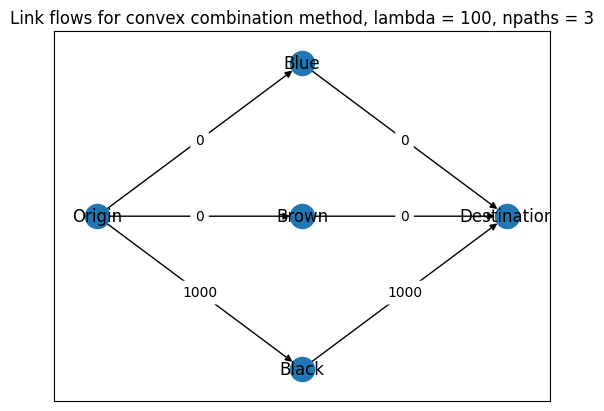

In [ ]:
# =============================================================================
# Build the graph
# =============================================================================
G = nx.DiGraph()

G.add_node('Origin', pos = (0, 1))
G.add_node('Black', pos = (1, 0))
G.add_node('Brown', pos = (1, 1))
G.add_node('Blue', pos = (1, 2))
G.add_node('Destination', pos = (2, 1))

G.add_edge('Origin', 'Black', length=1.9, flow=0) #Black
G.add_edge('Black', 'Destination', length=0, flow=0) #Black
G.add_edge('Origin', 'Brown', length=2.6, flow=0) #Brown
G.add_edge('Brown', 'Destination', length=0, flow=0) #Brown
G.add_edge('Origin', 'Blue', length=3.1, flow=0) #Blue
G.add_edge('Blue', 'Destination', length=0, flow=0) #Blue

# =============================================================================
# Find paths (lambda = 0.4, npaths = 5, flow-delay = length+0.1x)
# =============================================================================

path = nx.dijkstra_path(G, 'Origin', 'Destination', weight='length') #shortest path with dijkstra needed to change to something in terms of time!

edges = G.edges
for i in range(len(path)-1):
    G[path[i]][path[i+1]]['flow'] = flow
sum(G[edge[0]][edge[1]]['flow']*G[edge[0]][edge[1]]['length'] for edge in edges)

# =============================================================================
# Draw the graph:
# =============================================================================
leng = {(n[0], n[1]): n[2]['length'] for n in G.edges(data=True)}
pos = {n[0]: n[1]['pos'] for n in G.nodes(data=True)}
fl = {(n[0], n[1]): round(n[2]['flow']) for n in G.edges(data=True)}

f, ax = plt.subplots()
ax.set_title('Link flows for convex combination method, lambda = ' + str(lamb) + ', npaths = ' + str(npaths))
nx.draw_networkx(G, pos=pos, with_labels=True, ax=ax)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=fl, rotate=False, ax=ax)

# f, ax = plt.subplots()
# ax.set_title("Total cost as a function of npaths and lambda (CCM)")
# plt.xlabel("lambda")
# plt.ylabel("Total cost (10k units)")
# for npaths in p:
#     ax.scatter(l, ttime[npaths], label="npaths = " + str(npaths))
#     ax.plot(l, ttime[npaths])
# ax.legend()